In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cloning Repos


In [ ]:
#!git clone https://github.com/AlexeyAB/darknet

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7 #run it later

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.94 MiB | 9.37 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [ ]:
!git clone https://github.com/varun-tokas/quickbrownfoxx     #update weights and add to file

Cloning into 'quickbrownfoxx'...
remote: Enumerating objects: 11708, done.
remote: Total 11708 (delta 0), reused 0 (delta 0), pack-reused 11708
Receiving objects: 100% (11708/11708), 66.38 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (7755/7755), done.


In [ ]:
!pip install -r /content/quickbrownfoxx/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


In [ ]:
%ls

drive/  quickbrownfoxx/  sample_data/  yolov7/


In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import subprocess

# Segmentation+Warping

In [ ]:
def importimage(filename):        #import the image
  image=cv2.imread(filename)
  # print(widt,heigt)
  return image 

In [ ]:
def runInferencenew(filename,input_dir):
  op=predict.run(weights='/content/drive/MyDrive/Segmentation/Yolov5Weights/Yolov5n/weights/best.pt',save_txt=True,source=filename,exist_ok=True)
  print(op)
  return op
  

In [ ]:
def getmbox(filename,image,input_dir):      #get all mask boundary points
  with open('/content/quickbrownfoxx/runs/predict-seg/exp/labels/'+filename[len(input_dir):].rstrip('jpeg')+'txt') as f:
    bbox=[]
    fl=0
    t=[]
    for x in next(f).split():       #reading file
      if fl==0:
        fl+=1
        continue
      if fl%2==0:
        t.append(float(x)*image.shape[0])
        bbox.append(t.copy())
      else:
        t.append(float(x)*image.shape[1])
      if(fl%2==0):
        t.clear()
      fl+=1
  return bbox 

In [ ]:
def dis2(c,d):
  return c*c+d*d

def getcorners2(filename,image,mbox):       #opencv corner coordinate function
  nim2=np.zeros((image.shape[0],image.shape[1],image.shape[2]))
  # cv2_imshow(cv2.fillConvexPoly(org_image.copy(),np.array(mbox,np.int32),color=(255,255,255)))
  nim=cv2.fillConvexPoly(nim2.copy(),np.array(mbox,np.int32),color=(255,255,255))
  # cv2_imshow(nim)
  img=nim
  # print(img.shape)
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)
  # print(gray.shape)
  blurred = cv2.bilateralFilter(gray, 9, 75, 75)                          #smoothes out the noise in the image
  _, thresh = cv2.threshold(np.uint8(blurred), 0, 255, cv2.THRESH_OTSU)   #automatic image thresholding

  contours, _ = cv2.findContours(np.uint8(blurred), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]

  perimeter = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

  # for point in approx:
  #     x, y = point[0]
  #     cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
  # cv2.drawContours(img, [approx], -1, (0, 255, 0))
  # cv2_imshow(img)
  dmin=10000000000
  ireq=-1
  for i in range(4):
    if dis2(approx[i][0][0],approx[i][0][1])<dmin:
      ireq=i
      dmin=dis2(approx[i][0][0],approx[i][0][1])
  # print([approx[ireq][0],approxpts[(ireq-1+4)%4][0],approxpts[(ireq-2+4)%4][0],approxpts[(ireq-3+4)%4][0]])
  return [approx[ireq][0],approx[(ireq-1+4)%4][0],approx[(ireq-2+4)%4][0],approx[(ireq-3+4)%4][0]]

In [ ]:
def getmbox(filename,image,i):      #get mask boundary points
  with open('/content/quickbrownfoxx/runs/predict-seg/exp'+str(i)+'/labels/'+filename.rstrip('jpeg')+'txt') as f:
    bbox=[]
    fl=0
    t=[]
    # print('reached')
    for x in next(f).split():
      if fl==0:
        fl+=1
        continue
      if fl%2==0:
        t.append(float(x)*image.shape[0])
        # print(fl,t)
        bbox.append(t.copy())
      else:
        # print(t)
        t.append(float(x)*image.shape[1])
      if(fl%2==0):
        t.clear()
      fl+=1
  return bbox 

In [ ]:
def getbbox(filename,image,i):      #get bounding box points
  bbox=[]
  with open('/content/quickbrownfoxx/runs/predict-seg/exp'+str(i)+'/labels/'+filename.rstrip('.jpeg')+'_bbox.txt') as f:
    # w, h = [int(x) for x in next(f).split()] # read first line
    array = []
    for x in next(f).split():
        array.append(float(x))
    # temp=cv2.imread('/content/yolov5/kamalnayanbajaj_micu_mon--15_2022_6_20_21_46_20.jpeg')
    bbox.append([np.int32((array[1]-(array[3])/2)*image.shape[1]),np.int32((array[2]-(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]+(array[3])/2)*image.shape[1]),np.int32((array[2]-(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]+(array[3])/2)*image.shape[1]),np.int32((array[2]+(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]-(array[3])/2)*image.shape[1]),np.int32((array[2]+(array[4])/2)*image.shape[0])])
  return bbox

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def warpimage(image,corners):        #apply warping to the image
  # url = "/content/yolov5/kamalnayanbajaj_micu_mon--15_2022_6_20_21_46_20.jpeg"
  # x1, y1 = [500, 190]   
  # x2, y2 = [790, 220]
  # x3, y3 = [787, 497]
  # x4, y4 = [504, 452]
  # print(corners)
  cornersp = np.float32([corners[0], corners[1], corners[2], corners[3]])

  # img = cv2.imread(filename)
  width, height = image.shape[1],image.shape[0]
  pts2 = np.float32([[0,0],[width,0],[width,height],[0,height]])
  matrix = cv2.getPerspectiveTransform(cornersp,pts2)
  output = cv2.warpPerspective(image,matrix,(width,height))
  # cv2_imshow(image)
  # cv2_imshow(output)
  return output
  # cv2.waitKey(0)
  # cv2.imwrite('/content/yolov5/theimage.png',output)

In [ ]:
def runsegmentation(filenames,input_dir):      #aggregate function - pass file name as input relative to /content/quickbrownfoxx/
    #note that first run is not saved as exp1 - so think accordingly
  t=0
  for filename in filenames:
    try:
      t_simp=time.time()
      image = importimage(filename)
      t_eimp=time.time()
      print('import time :',t_eimp-t_simp)
      t_sinf=time.time()
      timetaken=runInferencenew(filename,input_dir)
      print("real inference time :",timetaken)
      t_einf=time.time()
      print('inference time :',t_einf-t_sinf)
      t_smbox=time.time()
      mbox=getmbox(filename,image,input_dir)
      t_embox=time.time();
      print('mbox time :',t_embox-t_smbox)
      # bbox=getbbox(filename,image,i)
      # coords=getcorners(bbox,mbox)
      t_sco=time.time()
      coords=getcorners2(filename,image,mbox)  #openCV corner function
      t_eco=time.time()
      print('getcorners2 time :',t_eco-t_sco)
      # print(coords)
      t_sw=time.time()
      final=warpimage(image,coords)
      t_ew=time.time()
      print('warp time :',t_ew-t_sw)
      # cv2_imshow(final)
      # plotim(image,final)
      # cv2_imshow(final)
      cv2.imwrite('/content/drive/MyDrive/Segmentation/Unlabelled extr2/'+filename[len(input_dir):],final)
      t_spl=time.time()
      # plotim(image,final)
      t_epl=time.time()
      print('plotting time :',t_epl-t_spl)
    except Exception:
      t+=1
  print('Failed on ', t, 'tests')
  return final                     #pipeline output

In [ ]:
def plotim(image,final):
  fig=plt.figure(figsize=(10,7))

  fig.add_subplot(2, 2, 1)
  plt.imshow(image[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("Initial")

  
  fig.add_subplot(2, 2, 2)
  plt.imshow(final[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("Final")

In [ ]:
def run_seg(images=['/content/quickbrownfoxx/aveksha_micu_mon--203_2023_1_5_12_0_21.jpeg'],input_dir='/content/quickbrownfoxx/'):
#images=['/content/quickbrownfoxx/aveksha_micu_mon--203_2023_1_5_12_0_21.jpeg']                                  #relative to root directory
#input_dir='/content/quickbrownfoxx/'                                               #relative to root directory
  output=[]
  t_s=time.time()
  output.append(runsegmentation(images,input_dir))
  t_e=time.time()
  print('total time :',t_e-t_s)

In [ ]:
# test_img = 'tokas2.jpeg'  #testing cell
# runsegmentation([test_img])

# Get requirements for text detection


In [ ]:
!pip install -r /content/yolov7/requirements.txt

# Image Processing

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/MyDrive/experiment/exp9.jpg', flags=cv2.IMREAD_COLOR)
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
cv2_imshow(image_sharp)

error: ignored

In [ ]:

def gaussian_kernel(kernel_size=3):
  h=np.gaussian(kernel_size, kernel_size/3).reshape(kernel_size,1)
  h=np.dot(h,h.transpose())
  h/=np.sum(h)
  return h

def wiener_filter(img, kernel, K):
  kernel/=np.sum(kernel)
  dummy=np.copy(img)
  dummy=np.fft2(dummy)
  kernel=np.fft2(kernel, s=img.shape)
  kernel=np.conj(kernel) / (np.abs(kernel) ** 2 + K)
  dummy = dummy * kernel
  dummy = np.abs(np.ifft2(dummy))
  return dummy

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col= X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [ ]:

restImg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_img=cv2.blur(restImg, ksize=(7,7))
noisy_img_1 = add_gaussian_noise(image)
# noisy_img_2 = add_gaussian_noise(blurred_img, sigma = 20)
# noisy_img_3 = add_gaussian_noise(blurred_img, sigma = 30)

kernel = gaussian_kernel(5)
filtered_img_1 = wiener_filter(noisy_img_1, kernel, K=10)
# filtered_img_2 = wiener_filter(noisy_img_2, kernel, K=10)
# filtered_img_3 = wiener_filter(noisy_img_3, kernel, K=10)
cv2_imshow(filtered_img_1)
# cv2_imshow(filtered_img_2)
# cv2_imshow(filtered_img_3)

In [ ]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)
cv2.imwrite('hsv.jpeg', hsv)

In [ ]:
dst = cv2.fastNlMeansDenoisingColored(hsv, None, 10, 10, 7, 15)
cv2_imshow(dst)

# cv2.imwrite("dst.jpg", dst)

In [ ]:
dst = cv2.fastNlMeansDenoisingColored(image_sharp, None, 10, 10, 7, 15)
cv2_imshow(dst)
cv2.imwrite("dst.jpg", dst)

In [ ]:
# define the alpha and beta
alpha = 1.5 # Contrast control
beta = 0 # Brightness control

# call convertScaleAbs function
adjusted = cv2.convertScaleAbs(image_sharp, alpha=alpha, beta=beta)
cv2_imshow(adjusted)
cv2.imwrite("adjusted.jpg", adjusted)

In [ ]:
image = cv2.imread("/content/drive/MyDrive/experiment/exp9.jpg", -1)

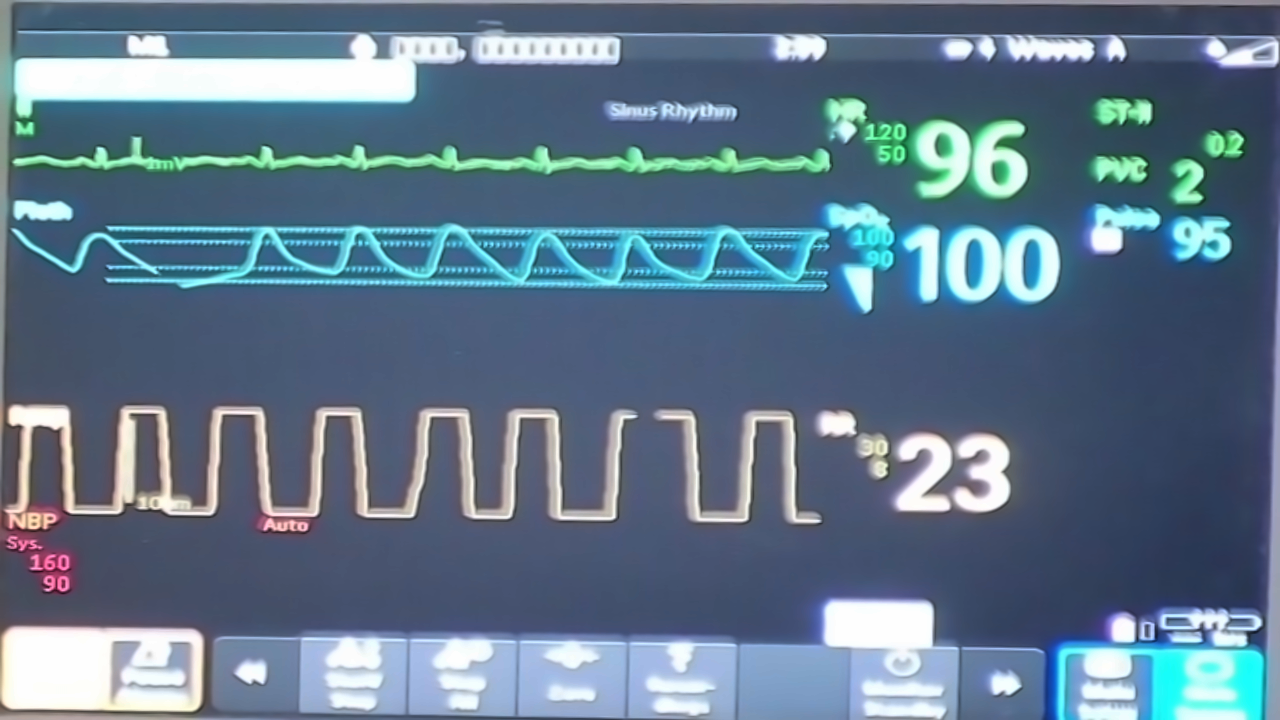

True

In [ ]:
#dst2 = cv2.fastNlMeansDenoisingColored(adjusted, None, 10, 10, 7, 15)
dst2 = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)
cv2_imshow(dst2)
output_img = "figure/dst2.jpg" 
cv2.imwrite(output_img, dst2)

In [ ]:
src = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
dst = cv2.equalizeHist(src)
cv2_imshow(dst)

In [ ]:
# cv2.cvtColor is applied over the
# image input with applied parameters
# to convert the image in grayscale
img_otsu = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
  
# applying Otsu thresholding
# as an extra flag in binary 
# thresholding     
ret, thresh1 = cv2.threshold(img_otsu, 120, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)     
  
# the window showing output image         
# with the corresponding thresholding         
# techniques applied to the input image    
cv2_imshow(thresh1)
cv2.imwrite("thresh1.jpeg", thresh1)  

In [ ]:
img_gray = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
edges = cv2.Canny(image=img_gray, threshold1=75, threshold2=100)
cv2_imshow(edges)

In [ ]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

In [ ]:
gammaImg = gammaCorrection(dst2, 0.8)
cv2_imshow(gammaImg)
cv2.imwrite("gammaImg.jpg",image_sharp)

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from PIL import Image
  
image = Image.open("dst2.jpg")
  
right = 300
left = 300
top = 300
bottom = 300
  
width, height = image.size
  
new_width = width + right + left
new_height = height + top + bottom
  
result = Image.new(image.mode, (new_width, new_height), (0, 0, 0))
  
result.paste(image, (left, top))
  
result.save('dst2_padded.jpg')

In [ ]:
image = cv2.imread("dst2_padded.jpg", -1)
image = cv2.resize(image, (0, 0), fx = 0.4, fy = 0.4)
cv2_imshow(image)
cv2.imwrite("dst2_resized.jpg", image)

In [ ]:
%cd /content/yolov7

/content/yolov7


# Monitor Classification

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=4, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Flatten(1,-1)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(14400, 64),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Softmax())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
def loadClassificationModel():
  classificationModel = torch.load('/content/drive/MyDrive/CloudPhysician/monitorClassification/model3.pth',map_location=torch.device(device))
  classificationModel.load_state_dict(torch.load('/content/drive/MyDrive/CloudPhysician/monitorClassification/model3_weights.pth', map_location=torch.device(device)))
  return classificationModel

In [ ]:
def getClassName(image_path, model):
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((256,256)),transforms.Normalize(mean, std)])
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      index, confidence = output.data.cpu().numpy().argmax(),output.data.cpu().numpy().max()
      classes = ['BPL-EliteView-EV10-B_Meditec-England-A','BPL-EliteView-EV100-C','BPL-Ultima-PrimeD-A','Nihon-Kohden-lifescope-A']
      class_name = classes[index]
      return class_name

# Text detection using yolo  and ocr 

In [ ]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

def detect(opt,printResult=True ,save_img=False):
    from models.experimental import attempt_load
    from utils.datasets import LoadStreams, LoadImages
    from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
    from utils.plots import plot_one_box
    from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
    source, weights, view_img, save_txt, imgsz, trace = opt['source'], opt['weights'], opt['view-img'], opt['save-txt'], opt['img-size'], not opt['no-trace']
    save_img = not opt['nosave'] and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt['project']) / opt['name'], exist_ok=opt['exist-ok']))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if trace:
        model = TracedModel(model, device, opt['img-size'])

    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt['augment'])[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt['augment'])[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes=opt['classes'], agnostic=opt['agnostic-nms'])
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            resultFound = dict()
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                
                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if printResult:
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        print(xywh)
                        if(int(cls) not in resultFound.keys()):
                          resultFound[int(cls)]=xywh
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt['save-conf'] else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

            # Print time (inference + NMS)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')
    return resultFound

def runYolo(weights = 'yolov7.pt', source='inference/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False):
    opt=dict()
    opt['source']=source
    opt['weights']=weights
    opt['img-size']=img_size
    opt['conf-thres']=conf_thres
    opt['iou-thres']=iou_thres
    opt['device']=device
    opt['view-img']=view_img
    opt['save-txt']=save_txt
    opt['save-conf']=save_conf
    opt['nosave']=nosave
    opt['classes']=classes
    opt['agnostic-nms']=agnostic_nms
    opt['augment']=augment
    opt['update']=update
    opt['project']=project
    opt['name']=name
    opt['exist-ok']=exist_ok
    opt['no-trace']=no_trace
    print(opt)
    #check_requirements(exclude=('pycocotools', 'thop'))
    resultArray=dict()
    with torch.no_grad():
        if opt['update']:  # update all models (to fix SourceChangeWarning)
            for opt['weights'] in ['yolov7.pt']:
                resultArray=detect(opt)
                strip_optimizer(opt['weights'])
        else:
            resultArray=detect(opt)
    return resultArray


In [ ]:
def get_bboxes(source_img, weightsPath):
  bboxes=runYolo(weights=weightsPath, img_size=608, conf_thres=0.1,source=source_img)
  return bboxes

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 49.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


In [ ]:
import easyocr
from matplotlib import pyplot as plt
reader=easyocr.Reader(['en'],gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def OCR(bounding_box, img):
  result=[]
  x_c=int(bounding_box[0])
  y_c=int(bounding_box[1])
  w=int(bounding_box[2])
  h=int(bounding_box[3])
  stro=int(x_c)-int(w/2)
  edr=int(x_c)+int(w/2)
  stc=int(y_c)-int(h/2)
  edc=int(y_c)+int(h/2)
  crop_img=img[stc:edc,stro:edr]
  result=reader.readtext(crop_img.copy())
  return (result,crop_img)

In [ ]:
def getVitalName(a):
    if a == 0:
        return 'HR'
    elif a == 1:
        return 'SBP'
    elif a == 2:
        return 'DBP'
    elif a == 3:
        return 'MAP'
    elif a == 4:
        return 'SPO2'
    elif a == 5:
        return 'RR'
    elif a == 6:
        return 'HR_W'
    elif a == 7:
        return 'RR_W'
    elif a == 8:
        return 'SPO2_W'

In [ ]:
def getVitalsWithClasses(img, bboxes):
  retlist = []
  img_height=int(img.shape[0])
  img_width=int(img.shape[1])
  for index in bboxes:
    coordis=bboxes[index]
    coordis = list(coordis)
    coordis[0]*=float(img_width)
    coordis[1]*=float(img_height)
    coordis[2]*=float(img_width)
    coordis[3]*=float(img_height)
    classname = getVitalName(index)
    if(classname in ['SPO2', 'RR', 'MAP', 'SBP', 'DBP','HR']):
      (result, cropimg) = OCR(coordis, img)
      print(classname,result)
      cv2_imshow(cropimg)
    else:
      get_dig_graph(coordis, img)


# Digitization

In [ ]:
def plotim_dig(image,final):
  fig=plt.figure(figsize=(10,7))

  fig.add_subplot(2, 2, 1)
  plt.imshow(image[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("before")

  
  fig.add_subplot(2, 2, 2)
  plt.show(final[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("after")

In [ ]:
def plotim(image,final):
  fig=plt.figure(figsize=(10,7))
  fig.add_subplot(2, 2, 1)
  plt.imshow(image[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("before")
  fig.add_subplot(2, 2, 2)
  plt.imshow(final[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("after")

In [ ]:
def digitize(crop_img,bbox):  
    hist = cv2.calcHist([crop_img], [0], None, [256], [0, 256])
    hist = [val[0] for val in hist]
    indices = list(range(0, 256))
    s = [(x,y) for y,x in sorted(zip(hist,indices), reverse=True)]
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    _, mask_r = cv2.threshold(red, s[1][0], 255, cv2.THRESH_BINARY_INV)
    _, mask_g = cv2.threshold(green, s[1][0], 255, cv2.THRESH_BINARY_INV)
    _, mask_b = cv2.threshold(blue, s[1][0], 255, cv2.THRESH_BINARY_INV)
    masked = np.dstack((red,green,blue))
    masked = cv2.cvtColor(masked,cv2.COLOR_RGB2GRAY)
    thresh = 128
    img_binary = cv2.threshold(masked, thresh, 255, cv2.THRESH_BINARY)[1]
    x_=[]
    y_=[]
    for i in range (0,img_binary.shape[0]):
      result = np.where(img_binary[i] == 255)[0]
      result1=[i]*len(result)
      x_=x_+result1
      y_=y_+result.tolist()
    return x_,y_

In [ ]:
def get_dig_graph(coordis,img):
  %matplotlib inline
  import matplotlib.pyplot as plt
  img_height=int(img.shape[0])
  img_width=int(img.shape[1])
  coordis = list(coordis)
  startRow=int(coordis[0])-int(coordis[2]/2)
  endRow=int(coordis[0])+int(coordis[2]/2)
  startCol=int(coordis[1])-int(coordis[3]/2)
  endCol=int(coordis[1])+int(coordis[3]/2)
  cropImg=img[startCol:endCol,startRow:endRow]
  x_,y_ = digitize(cropImg, coordis.copy())
  # print(type(x_), len(x_))
  # print(len( y_ ))
  # print(x_,y_)
  plt.gca().invert_yaxis()
  plt.scatter(y_,x_, s=0.1)
  plt.show()

# Main cell

In [ ]:
import time


In [ ]:
%cd /content/quickbrownfoxx 
# initial_img = 'tokas2.jpeg'
# pinit = cv2.imread('/content/quickbrownfoxx/' + initial_img)
# start1 = time.time()
# seg_outputs = runsegmentation([initial_img])
# end1 = time.time()
# #print("segmentation time is: " (end1-start1) * 10**3, "ms")
# #seg_outputs[0]
# img_path = seg_outputs[1]
#plt.imshow(img_path)
img_path = '/content/yolov7/test7.jpg'
img = cv2.imread(img_path, -1)
pinit = img.copy()
img_path1 = img_path.lstrip('/content/yolov7/')
%cd /content/yolov7
start2 = time.time()
classificationModel = loadClassificationModel()
img_resized = cv2.resize(img, (256,256))
className = getClassName(img_resized, classificationModel)
weightsPath = '/content/drive/MyDrive/CloudPhysician/monitorSegmentation/'
weightsPath = weightsPath + className+'.pt'
bboxes = get_bboxes('test7.jpg', weightsPath)
print(bboxes)
if len(bboxes) < 6:
  print("DO NOT CONTINUE PIPELINE")
else:
  print("CONTINUE PIPELINE")
getVitalsWithClasses(img, bboxes)
# end2 = time.time()

imgResized = cv2.resize(img,  (800, 794),interpolation = cv2.INTER_CUBIC)
get_dig_graph(bboxes,imgResized)
# end3 = time.time()

# plotim(pinit,img)
# plotim(img,img1)

#img = cv2.imread('thresh1.jpeg', -1)
#getVitalsWithClasses(img, bboxes)

/content/quickbrownfoxx


AttributeError: ignored

In [ ]:
plt.imshow(img1)
img2 = cv2.resize(img1,  (800, 794),interpolation = cv2.INTER_CUBIC)
img2.shape
plt.imshow(img2)